In [1]:
from sklearn.ensemble import GradientBoostingRegressor
from data import *
from model import *

taxi_type = GREEN
train_sql = getSqlForModeling(taxi_type, isTrain=True)
test_sql = getSqlForModeling(taxi_type, isTrain=False)



model = GradientBoostingRegressor(n_estimators=500, 
                                  learning_rate=0.1, 
                                  max_depth=3,
                                  validation_fraction=0.1, 
                                  n_iter_no_change=10)

# Training
with DR.engn.connect() as conn:
    processed = 0
    for df in pd.read_sql(train_sql, conn, chunksize=CHUNK_SIZE):
        processed += len(df)
        X = df[FEATURES]
        y = df[VARIABLE]

        model.fit(X, y)
        O.out(f'Trained {processed} rows')

storeModel(model, f'{taxi_type}_{VARIABLE}_{GRADIENT_BOOST}')

# Predictions
with DR.engn.connect() as conn:
    processed = 0
    y_test = []
    y_pred = []
    for df in pd.read_sql(test_sql, conn, chunksize=CHUNK_SIZE):
        processed += len(df)
        X = df[FEATURES]
        y_test.append(df[VARIABLE])

        y_pred.append(model.predict(X))
        O.out(f'Predicted {processed} rows')

# Performance
merged_y_test = pd.concat(y_test, ignore_index=True)
merged_y_pred = np.concatenate(y_pred)

showPerformance(merged_y_test, merged_y_pred)

sql engine ready
Model Accuracy Metrics:
Mean Absolute Error (MAE): 0.96
Root Mean Squared Error (RMSE): 2.81
R-squared (Accuracy): 0.94


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from model import *

data = readData(taxi_type=GREEN)

X = data[FEATURES_SET1]
y = data[VARIABLE]

# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Gradient Boosting Model
model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, 
                                  validation_fraction=0.1, 
                                  n_iter_no_change=10,      
                                  max_depth=3, random_state=42)
model.fit(X_train, y_train)

# 5. Predictions
y_pred = model.predict(X_test)



1675331
1011017
802356
757206


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import plotly.graph_objects as go

# Calculate Model Accuracy Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Model Accuracy Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (Accuracy): {r2:.2f}")

# Limit data to 150 samples for visualization
samples_to_plot = 150
y_test_limited = y_test[:samples_to_plot].reset_index(drop=True)
y_pred_limited = y_pred[:samples_to_plot]

# Create Line Chart with Plotly
fig = go.Figure()

# Actual Values
fig.add_trace(go.Scatter(
    x=y_test_limited.index, 
    y=y_test_limited, 
    mode="lines+markers", 
    name="Actual",
    line=dict(color="blue")
))

# Predicted Values
fig.add_trace(go.Scatter(
    x=y_test_limited.index, 
    y=y_pred_limited, 
    mode="lines+markers", 
    name="Predicted",
    line=dict(color="orange")
))

# Customize Layout
fig.update_layout(
    title="Actual vs Predicted Fare Amount (Limited to 150 Samples)",
    xaxis_title="Sample Index",
    yaxis_title="Fare Amount ($)",
    legend=dict(x=0.5, y=1.15, xanchor="center", yanchor="top"),
    template="plotly_white"
)

# Show the plot
fig.show()


Model Accuracy Metrics:
Mean Absolute Error (MAE): 2.04
Root Mean Squared Error (RMSE): 4.34
R-squared (Accuracy): 0.87


In [ ]:
param_grid = {
    "n_estimators": [300, 500, 700],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "subsample": [0.6, 0.8, 1.0]
}

# Perform grid search
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring="r2",  # Optimize for R-squared
    verbose=2
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best R2 Score:", grid_search.best_score_)


In [ ]:
from data import *

cacheSql(DAILY_AVGS, DAILY_AVGS_CACHE, GREEN)
cacheSql(HOURLY_AVGS, HOURLY_AVGS_CACHE, GREEN)
cacheSql(DAILY_AVGS, DAILY_AVGS_CACHE, YELLOW)
cacheSql(HOURLY_AVGS, HOURLY_AVGS_CACHE, YELLOW)

In [ ]:
from data import *
from lib import *

# getBoxPlotData(GREEN)
data = loadObject(f'{GREEN}_{BOX_PLOT_CACHE}', 'cache')
data.keys()



In [ ]:
import pandas as pd
import plotly.graph_objects as go
import streamlit as st

from data import *

color_list = ["red", "blue", "green", "yellow", "orange", "purple", "pink"]

def plotByDayOfWeek(data, category, x_fld, y_fld):
    fig = go.Figure()

    for ind, d in enumerate(data[category].unique()):
        d_data = data[data[category] == d]
        # data.reset_index(inplace=True)
        fig.add_trace(go.Scatter(
            x=d_data[x_fld],  # Use the DataFrame index for the x-axis
            y=d_data[y_fld],
            mode="lines+markers",
            name=f"{d} {y_fld}",
            line=dict(color=color_list[ind]),
            marker=dict(size=6)
        ))
        

    # Update layout
    fig.update_layout(
        title=f"{y_fld} by {category}",
        xaxis_title=x_fld,
        yaxis_title=y_fld,
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True),
        template="plotly_white",
        height=1000
    )
    
    fig.show()


# get data
# df = getCachedSql(DAILY_AVGS_CACHE, YELLOW)
df = getCachedSql(HOURLY_AVGS_CACHE, YELLOW)
plotByDayOfWeek(df, 'time_of_day', 'hour', 'avg_total_amount')

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import streamlit as st

from data import *

color_list = ["red", "blue", "green", "yellow", "orange", "purple", "pink"]

def plotByDayOfWeek(data):
    fig = go.Figure()

    for ind, d in enumerate(data["day_of_week"].unique()):
        d_data = data[data["day_of_week"] == d]
        # data.reset_index(inplace=True)
        fig.add_trace(go.Scatter(
            x=d_data['day'],  # Use the DataFrame index for the x-axis
            y=d_data["trip_count"],
            mode="lines+markers",
            name=f"{d} Avg Tips",
            line=dict(color=color_list[ind]),
            marker=dict(size=6)
        ))
        

    # Update layout
    fig.update_layout(
        title="Average Tip Amount VS Day of Week",
        xaxis_title="Days",
        yaxis_title="Average Tip Amount ($)",
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True),
        template="plotly_white",
        height=1000
    )
    
    # Display the plot in Streamlit
    # st.plotly_chart(fig, use_container_width=True)
    fig.show()


# get data
df = getCachedSql(DAILY_AVGS_CACHE, YELLOW)
# call plot_avg_tip_by_day_of_week(data)
plotByDayOfWeek(df)

sql engine ready
Mean Squared Error: 7.875580568320201


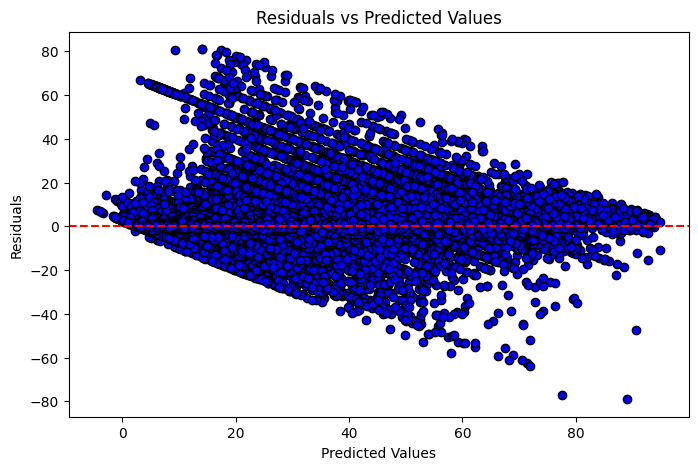

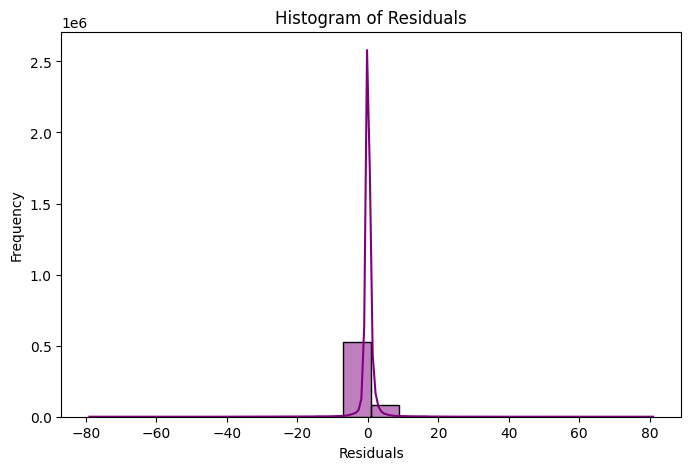

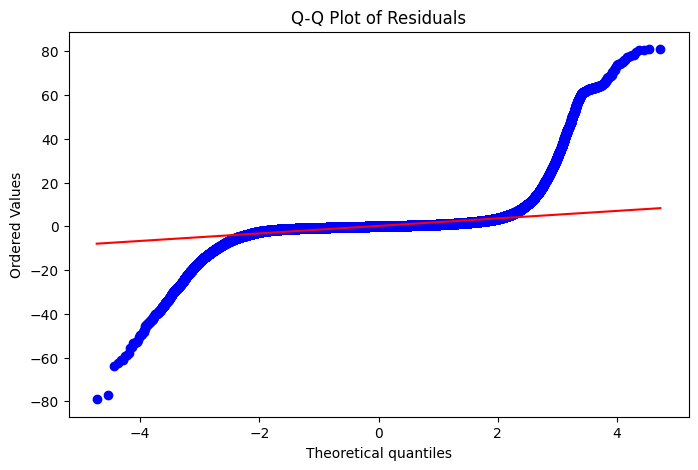

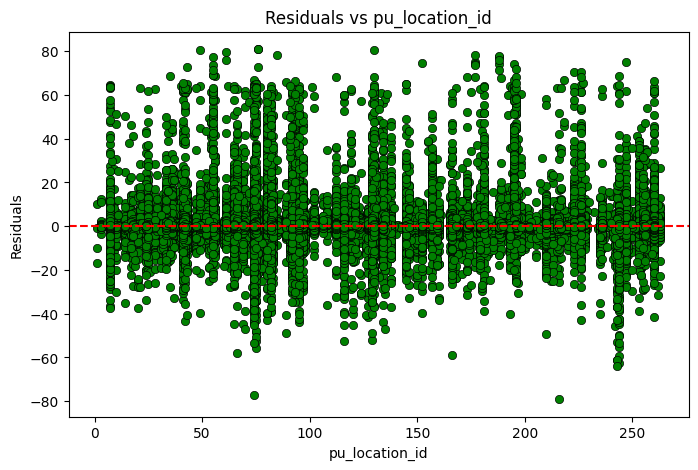

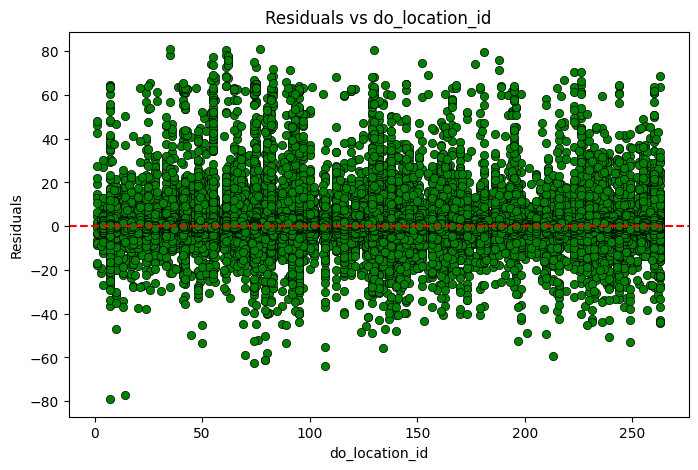

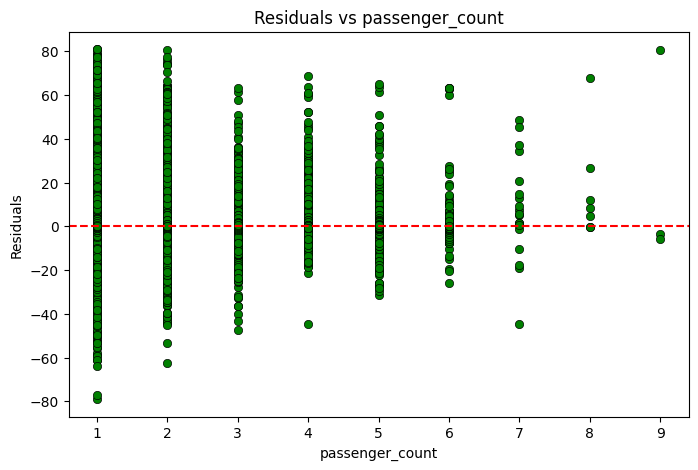

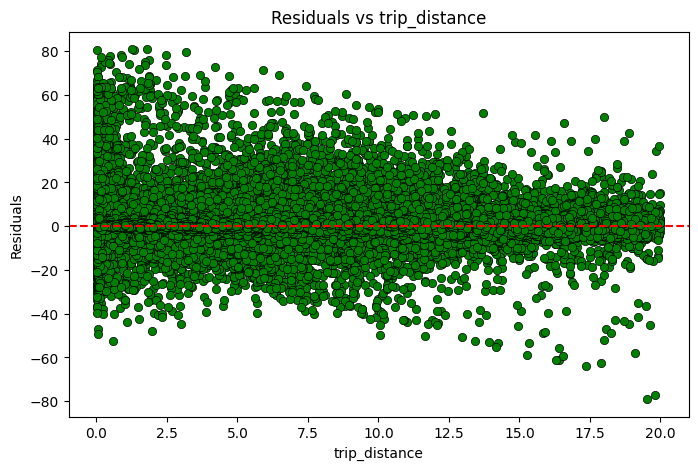

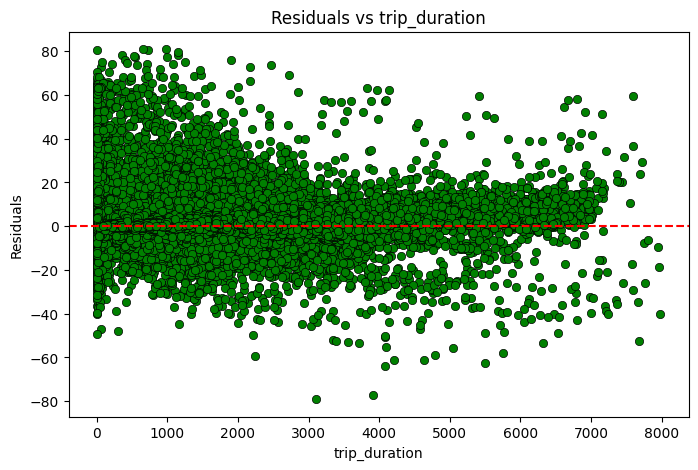

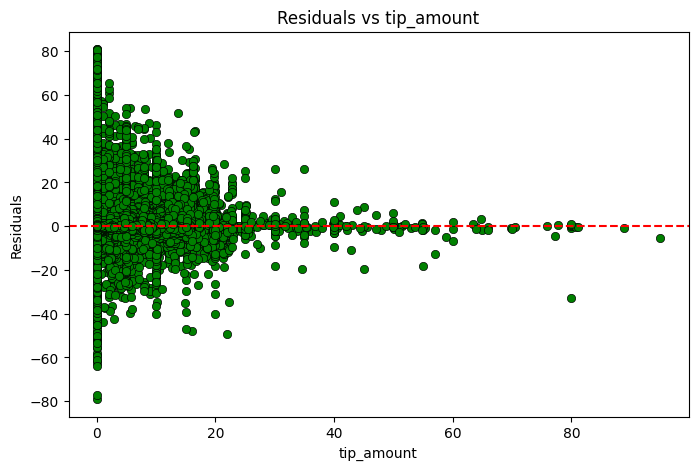

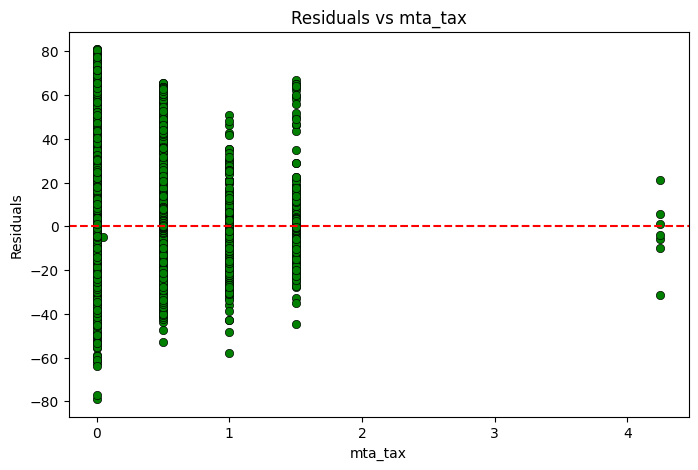

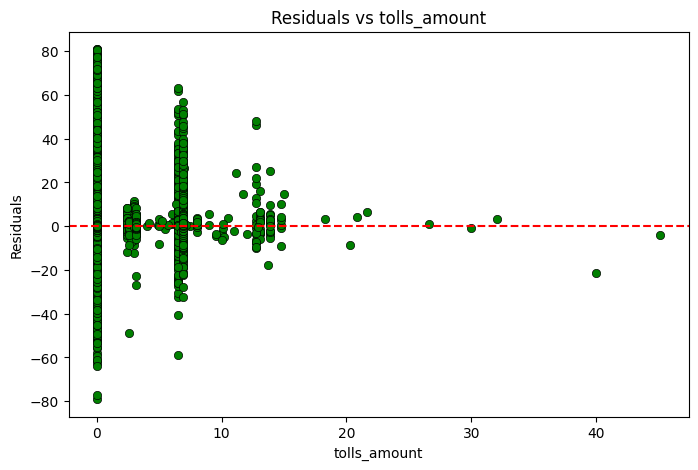

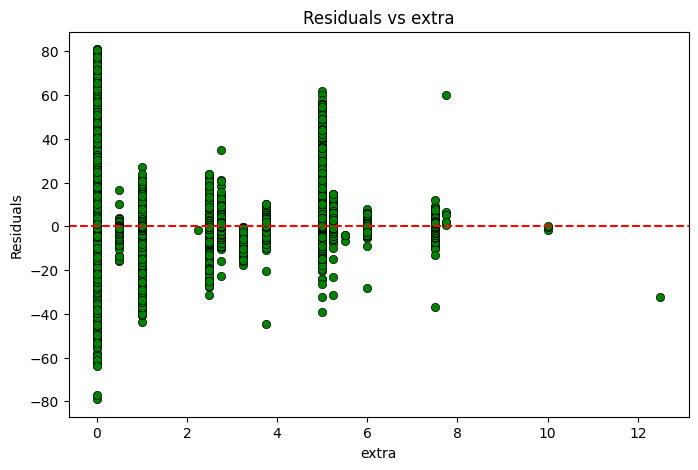

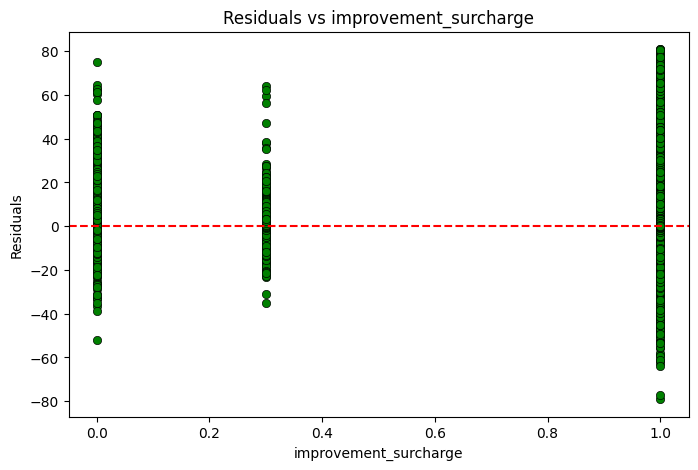

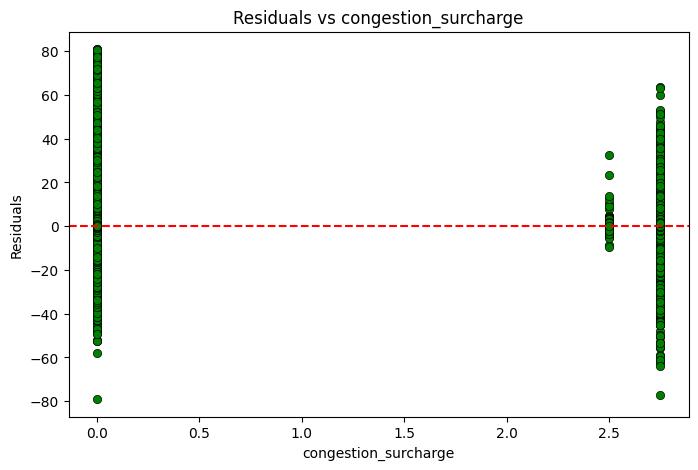

In [1]:
# Residual Analysis
from data import *
from model import *

taxi_type = GREEN
# train_sql = getSqlForModeling(taxi_type, isTrain=True)
test_sql = getSqlForModeling(taxi_type, isTrain=False)

model = loadModel(f'{taxi_type}_{VARIABLE}_{GRADIENT_BOOST}')

# Predictions
with DR.engn.connect() as conn:
    processed = 0
    y_t_chunk = []
    y_p_chunk = []
    X_t_chunk = []
    for df in pd.read_sql(test_sql, conn, chunksize=CHUNK_SIZE):
        processed += len(df)
        X = df[FEATURES]
        X_t_chunk.append(X)
        y_t_chunk.append(df[VARIABLE])

        y_p_chunk.append(model.predict(X))
        O.out(f'Predicted {processed} rows')

# Performance
X_test = pd.concat(X_t_chunk, ignore_index=True)
y_test = pd.concat(y_t_chunk, ignore_index=True)
y_pred = np.concatenate(y_p_chunk)


residualAnalysis(X_test, y_test, y_pred)